In [1]:
#Ideas
#Track down the incorrect predictions and see where they are in the distribition of the rest of the data
#Softmax function at the output layer?
#Make sure the weight initialization is random each time
#Can you somehow control the weight initialization to make sure its in a small range?

In [2]:
#HYPERPARAMETERS:
#-Activation function
#-Weight initialisation
#-Loss function
#-Training Algorithms
#-Training Algorithm parameters
#-Learning rate

In [3]:
#Previous Configurations

#Model 1
# model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

# learning_rate = 0.01
# criterion = nn.MSELoss()
# # criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import random
import copy
import seaborn as sns

In [5]:
with open('almonds_prep.pickle','rb') as file:
    All = pickle.load(file)

In [6]:
def myMSE(pred,true):
    return ((pred-true)**2).mean()

def convert(yout):
    y_out = copy.deepcopy(yout)
    for h in range(y_out.shape[0]):
        y_out[h][y_out[h] == y_out[h].max()] = 1
        y_out[h][y_out[h] != y_out[h].max()] = 0
    return y_out

def data_shuffler(X,Y,Y_binary):
    idxs = np.arange(0,len(X))
    random.shuffle(idxs)
    
    X_new = X[idxs]
    Y_new = Y[idxs]
    Y_binary_new = Y_binary[idxs]
    return X_new,Y_new,Y_binary_new

def batch_maker(X,Y,Y_binary,num_batches): #X,Y-> shuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/num_batches))
#     print(div)
    
    if num_batches == 1:
        return X,Y,Y_binary
    cnt1 = 0
    cnt2 = div
    Xbatch = []
    Ybatch = []
    Y_binary_batch = []
    for i in range(num_batches-1):
        
        Xbatch.append(X[cnt1:cnt2,:])
        Ybatch.append(Y[cnt1:cnt2])
        Y_binary_batch.append(Y_binary[cnt1:cnt2,:])

        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xbatch.append(X[cnt1:,:])
    Ybatch.append(Y[cnt1:])
    Y_binary_batch.append(Y_binary[cnt1:,:])

    return Xbatch,Ybatch,Y_binary_batch

def kfold_maker(X,Y,k): #X,Y-> unshuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/k))
#     print(div)
    
    if k == 1:
        return X,Y
    cnt1 = 0
    cnt2 = div
    Xfolds = []
    Yfolds = []
    for i in range(k-1):
        
        Xfolds.append(X[cnt1:cnt2,:])
        Yfolds.append(Y[cnt1:cnt2,:])
        
        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xfolds.append(X[cnt1:,:])
    Yfolds.append(Y[cnt1:,:])

    return Xfolds,Yfolds

def accuracy_calc(ytrain_pred, ytrain_target, ytest_pred, ytest_target):
    
    cnt_train = 0

    for h in range(len(ytrain_pred)):
        if sum(ytrain_pred[h,:] == ytrain_target[h,:]) < ytrain_target.shape[1]:
            cnt_train = cnt_train + 1
    incorr_pred_train = cnt_train

    cnt_test = 0
    for j in range(len(ytest_pred)):
        if sum(ytest_pred[j,:] == ytest_target[j,:]) < ytest_target.shape[1]:
            cnt_test = cnt_test + 1
    incorr_pred_test = cnt_test
    return incorr_pred_train, incorr_pred_test

In [7]:
class myNN(nn.Module):
    
    def __init__(self,n_input_features,n_output_features,n_layers_neurons):
        """
        n_input_features = Number of input features
        n_output_features = Number of output features
        n_layers_neurons = Dictionary of HIDDEN layer number and number of neurons in layer
           e.g.  3 hidden layers with 4, 2, and 7 neurons, respectively==> {1:4, 2: 2, 3: 7}
        
        """
        
        super().__init__()
        self.n_hidden_layers = len(list(n_layers_neurons)) #number of hidden layers
        #Creating all the layers
        
        self.layers = nn.ModuleList([nn.Linear(in_features = n_input_features, out_features = n_layers_neurons[1])])#First hidden layer
        
        for n in range(len(n_layers_neurons)-1):
            
            #All hidden layers
            self.layers.append(nn.Linear(in_features = n_layers_neurons[n+1], out_features = n_layers_neurons[n+2]))
            
        self.layers.append(nn.Linear(in_features = n_layers_neurons[list(n_layers_neurons)[-1]], out_features = n_output_features)) #Output layer

        
    def forward(self,x):
        
        #Hidden layers
        ys = []
        ys.append(nn.Tanh()(self.layers[0](x)))
#         print('First layer:',ys)
        for i in range(self.n_hidden_layers - 1):
#             print(i)
            net = self.layers[i+1](ys[i])
            ys.append(nn.Tanh()(net)) #Hidden layers
        
        net_output = self.layers[-1](ys[-1])
        output = nn. Softmax(dim=1)(net_output)
        return output,net_output

In [8]:
Xnum = np.vstack((All[0],All[1],All[2]))
print(Xnum.shape)

(2803, 13)


In [9]:
#Classes: 'MAMRA = [1,0,0]', 'SANORA = [0,1,0]', 'REGULAR' = [0,0,1]
Ynum = []
n_classes = 3
for n in range(len(Xnum)):
    if Xnum[n,-1] == "MAMRA":
        Ynum.append([1,0,0,0])
        
    elif Xnum[n,-1] == "SANORA":
        Ynum.append([0,1,0,1])
        
    elif Xnum[n,-1] == "REGULAR":
        Ynum.append([0,0,1,2])
        
    else:
        print(f"Error row index: {n}")

Xnum = Xnum[:,:-1]
Ynum = np.array(Ynum)
print(f"Input shape: {Xnum.shape}")
print(f"Output shape: {Ynum.shape}")

Input shape: (2803, 12)
Output shape: (2803, 4)


In [10]:
Xnum_train,_,Ynum_train,_ = train_test_split(Xnum,Ynum,test_size = 0.3)
print("X train: ", Xnum_train.shape)
print("Y train: ", Ynum_train.shape)

X_trainb = torch.tensor(Xnum_train.astype(np.float32))
Y_trainb = torch.tensor(Ynum_train,dtype=torch.long)

X train:  (1962, 12)
Y train:  (1962, 4)


In [11]:
criterion = nn.CrossEntropyLoss(reduction = 'none')
n_classes = 3
k = 5 #Number of folds
Xfolds,Yfolds = kfold_maker(X_trainb,Y_trainb,k = k)
print("Number of folds:",len(Xfolds))
print("Percentage of each fold:", len(Xfolds[0])/len(X_trainb)*100)

Number of folds: 5
Percentage of each fold: 20.03058103975535


In [12]:
def CV_model(eta_low, eta_high):
    losses_train_run = [] #Training loss for entire training set of each kfold run
    losses_test_run = []
    num_epochs_run = []

    losses_train_kfold = []
    losses_test_kfold = []

    accuracy_train = []
    accuracy_test = []

    for i in range(k): #for each k-fold run...

        model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

        optimizer = torch.optim.Rprop(model.parameters(),etas = (eta_low,eta_high))

        print(f"K = {i + 1}")
        losses_train = [] #Losses for each epoch
        losses_test = []
        
        #Splitting the training and testing folds
        Xfolds_mod = copy.deepcopy(Xfolds)
        Yfolds_mod = copy.deepcopy(Yfolds)

        XTestFold = Xfolds_mod.pop(i) #The fold that will be used for testing
        YTestFold = Yfolds_mod.pop(i)

        XTrainFold = Xfolds_mod #The rest of the folds used for training
        YTrainFold = Yfolds_mod

        #Combining the training folds
        XTrainFold = torch.concatenate(XTrainFold,axis = 0)
        YTrainFold = torch.concatenate(YTrainFold,axis = 0)
        print("Validation training data shape X:", XTrainFold.shape)
        print("Validation training data shape Y:", YTrainFold.shape)

        #Standardising the whole validation data on the training validation data
        sc = StandardScaler()
        XTrainFold = torch.tensor(sc.fit_transform(XTrainFold),dtype = torch.float32)
        XTestFold = torch.tensor(sc.transform(XTestFold),dtype = torch.float32)

        #Splitting the target data into binary and index
        YTrainFold_bin = YTrainFold[:,:-1]
        YTrainFold_idx = YTrainFold[:,-1]

        YTestFold_bin = YTestFold[:,:-1]
        YTestFold_idx = YTestFold[:,-1]

        num_epochs = 0
        tol = 8e-3 #tells us when to stop training
        error = 100
        max_epoch = 500
        while (error > tol) and num_epochs < max_epoch:

            num_epochs += 1
            #Shuffling the training validation data
            X_train,Y_train,Y_binary_train = data_shuffler(XTrainFold,YTrainFold_idx,YTrainFold_bin)

            #Divide the training data into batches
            num_batches = 1
            Xbatches, Ybatches,YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        #=======================TRAINING================================
            for iteration in range(num_batches): #for each batch...
                
                if num_batches == 1:
                    X_train_batch = Xbatches
                    Y_train_batch = Ybatches
                    Y_train_binary_batch = YBinaryBatches
                    
                else:     

                    X_train_batch = Xbatches[iteration]
                    Y_train_batch = Ybatches[iteration]
                    Y_train_binary_batch = YBinaryBatches[iteration]

                #Forward pass
                ypred_train,output_net = model(X_train_batch) #net_ouput is the output before the activation function of the output layer. This goes into the loss function.

                #Compute loss
                loss_train = criterion(output_net,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

                #Backward pass
                loss_train.backward()

                #Update weights
                optimizer.step()
                optimizer.zero_grad()

            #This happens when we've run through all batches
            with torch.no_grad():

                ypred_train_epoch,output_net_train_epoch = model(X_train)
                ypred_test_epoch,output_net_test_epoch = model(XTestFold)

                loss_train_epoch = criterion(output_net_train_epoch,Y_train).sum()/(n_classes*len(Y_train))
                losses_train.append(loss_train_epoch)

                loss_test_epoch = criterion(output_net_test_epoch,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
                losses_test.append(loss_test_epoch)

                error = ((ypred_train_epoch - Y_binary_train)**2).mean()
    #=======================DONE TRAINING================================
        losses_train_kfold.append(losses_train)
        losses_test_kfold.append(losses_test)

        if num_epochs == max_epoch:
            print("Training Stopped due to maximum number of iterations reached")

        num_epochs_run.append(num_epochs)

        #TESTING
        with torch.no_grad():

            #Final training and testing for a kfold run
            ypred_train_fold,output_net_train_fold = model(XTrainFold)
            ypred_test_fold,output_net_test_fold = model(XTestFold)

            loss_train_fold = criterion(output_net_train_fold,YTrainFold_idx).sum()/(n_classes*len(YTrainFold_idx))
            losses_train_run.append(loss_train_fold)

            loss_test_fold = criterion(output_net_test_fold,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
            losses_test_run.append(loss_test_fold)
            print(f"Training loss: {loss_train_fold}")
            print(f"Testing loss: {loss_test_fold}")

            #Accuracy Calculation
            Ypred_train_fold = convert(ypred_train_fold)
            Ypred_test_fold = convert(ypred_test_fold)

            cnt_train,cnt_test = accuracy_calc(Ypred_train_fold, YTrainFold_bin, Ypred_test_fold, YTestFold_bin)
            accuracy_train.append(100-(cnt_train/len(Ypred_train_fold)*100))
            accuracy_test.append(100-(cnt_test/len(Ypred_test_fold)*100))
            print("Accuracy Train:", 100-(cnt_train/len(Ypred_train_fold)*100))
            print("Accuracy Test:", 100-(cnt_test/len(Ypred_test_fold)*100))

    losses_train_run = torch.tensor(losses_train_run)
    losses_test_run = torch.tensor(losses_test_run)

    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)

    avg_train_loss = losses_train_run.mean()
    avg_test_loss = losses_test_run.mean()

    avg_train_acc = accuracy_train.mean()
    avg_test_acc = accuracy_test.mean()

    std_loss_train = torch.sqrt(torch.var(losses_train_run))
    std_loss_test = torch.sqrt(torch.var(losses_test_run))
    
    std_acc_train = torch.sqrt(torch.var(accuracy_train))
    std_acc_test = torch.sqrt(torch.var(accuracy_test))
    return {"LossTrain":losses_train_run,
            "LossTest":losses_test_run,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
            "AvgTrainLoss":avg_train_loss,
            "AvgTestLoss":avg_test_loss,
            "AvgTrainAcc":avg_train_acc,
            "AvgTestAcc":avg_test_acc,
            "StdTrainLoss":std_loss_train,
           "StdTestLoss":std_loss_test,
           "AllLossTrain":losses_train_kfold,
           "AllLossTest": losses_test_kfold,
           "TotNumEpochs":num_epochs_run,
           "StdAccTrain":std_acc_train,
           "StdAccTest":std_acc_test}

In [13]:
# test = CV_model(learning_rate = 0.01)

In [14]:
# fig0, ax0 = plt.subplots(k,1,figsize = (10,8),layout = 'constrained')

# for i in range(k):
#     ax0[i].set_yscale('log')
#     ax0[i].plot(test["AllLossTrain"][i],color='b',marker = 'o')
#     ax0[i].plot(test["AllLossTest"][i],color='r',marker = 'o')
#     ax0[i].set_xlim()

In [15]:
#Rprop cannot seem to get over the 97% accuracy mark
# learning_rate_values = torch.arange(0.01,0.03,0.001)
# etas=(0.5, 1.2)
# learning_rate_values = torch.tensor([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
eta_low = torch.arange(0.1,1,0.1)
eta_high = torch.arange(1.1,2.0,0.1)

print(eta_low)
print(eta_high)

nlow, nhigh = torch.meshgrid(eta_low,eta_high)
total = len(eta_low)*len(eta_high)

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000])
tensor([1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000, 1.9000])


D:\Anaconda_installation\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
row = 0
colm = 0
results = []
for t in range(total):
    if colm == nlow.shape[1]:
        colm = 0
        row += 1
    
    ans = CV_model(nlow[row,colm],nhigh[row,colm])
    results.append(ans)
    colm += 1
    
    print(f"=======Done {t + 1}========")

K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.018048781901597977
Testing loss: 0.021256500855088234
Accuracy Train: 98.8527724665392
Accuracy Test: 98.47328244274809
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.016846906393766403
Testing loss: 0.04585544764995575
Accuracy Train: 98.40662842574889
Accuracy Test: 96.43765903307889
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.015731342136859894
Testing loss: 0.038054704666137695
Accuracy Train: 98.59783301465902
Accuracy Test: 97.45547073791349
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019191468134522438
Testing loss: 0.07457499206066132
Accuracy Train: 98.7253027405991
Accuracy 

Training loss: 0.017496082931756973
Testing loss: 0.07357142865657806
Accuracy Train: 98.7253027405991
Accuracy Test: 96.18320610687023
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019415011629462242
Testing loss: 0.041856247931718826
Accuracy Train: 98.7253027405991
Accuracy Test: 95.67430025445293
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.02073284238576889
Testing loss: 0.05927690863609314
Accuracy Train: 98.59783301465902
Accuracy Test: 95.67430025445293
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.01788518764078617
Testing loss: 0.04468553140759468
Accuracy Train: 98.91857506361323
Accuracy Test: 98.2051282051282
=======Done 7========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation tra

Training loss: 0.015536516904830933
Testing loss: 0.04339015856385231
Accuracy Train: 98.40662842574889
Accuracy Test: 97.45547073791349
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.017129354178905487
Testing loss: 0.025095954537391663
Accuracy Train: 98.60050890585242
Accuracy Test: 98.97435897435898
=======Done 13========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.01840844750404358
Testing loss: 0.02049870975315571
Accuracy Train: 98.8527724665392
Accuracy Test: 98.21882951653944
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.018902873620390892
Testing loss: 0.04065489396452904
Accuracy Train: 98.59783301465902
Accuracy Test: 96.18320610687023
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation

Training loss: 0.01518301386386156
Testing loss: 0.012779632583260536
Accuracy Train: 98.7253027405991
Accuracy Test: 98.72773536895674
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.020948464050889015
Testing loss: 0.05806474760174751
Accuracy Train: 98.59783301465902
Accuracy Test: 96.69211195928753
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.01759088598191738
Testing loss: 0.04958393797278404
Accuracy Train: 98.91650732950924
Accuracy Test: 97.45547073791349
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.012402921915054321
Testing loss: 0.17183029651641846
Accuracy Train: 98.47036328871893
Accuracy Test: 94.14758269720102
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: 

Accuracy Train: 98.59783301465902
Accuracy Test: 95.92875318066157
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019121792167425156
Testing loss: 0.03818955272436142
Accuracy Train: 98.7253027405991
Accuracy Test: 96.94656488549619
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.01694127544760704
Testing loss: 0.04562635347247124
Accuracy Train: 98.59783301465902
Accuracy Test: 97.70992366412214
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.015068789944052696
Testing loss: 0.02039721980690956
Accuracy Train: 98.85496183206106
Accuracy Test: 97.94871794871796
=======Done 26========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.01684847

Training loss: 0.01753898337483406
Testing loss: 0.03728148713707924
Accuracy Train: 98.66156787762907
Accuracy Test: 97.20101781170483
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.013492759317159653
Testing loss: 0.019082432612776756
Accuracy Train: 97.58269720101781
Accuracy Test: 97.94871794871796
=======Done 32========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019551822915673256
Testing loss: 0.02318459190428257
Accuracy Train: 98.7253027405991
Accuracy Test: 98.72773536895674
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.014010727405548096
Testing loss: 0.04649500921368599
Accuracy Train: 98.78903760356916
Accuracy Test: 96.18320610687023
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation

Training loss: 0.020578833296895027
Testing loss: 0.018767008557915688
Accuracy Train: 98.79134860050891
Accuracy Test: 99.74358974358974
=======Done 38========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.011602889746427536
Testing loss: 0.01169827114790678
Accuracy Train: 98.78903760356916
Accuracy Test: 98.9821882951654
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.018015647307038307
Testing loss: 0.11122222244739532
Accuracy Train: 98.78903760356916
Accuracy Test: 97.96437659033079
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.018740607425570488
Testing loss: 0.03329227864742279
Accuracy Train: 98.78903760356916
Accuracy Test: 96.69211195928753
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validatio

Training Stopped due to maximum number of iterations reached
Training loss: 0.267924427986145
Testing loss: 0.28011682629585266
Accuracy Train: 57.93499043977056
Accuracy Test: 53.18066157760814
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.23897723853588104
Testing loss: 0.23729225993156433
Accuracy Train: 64.37221159974506
Accuracy Test: 62.086513994910945
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.26608914136886597
Testing loss: 0.28033849596977234
Accuracy Train: 61.12173358827279
Accuracy Test: 57.76081424936387
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations 

Training loss: 0.016968369483947754
Testing loss: 0.050701823085546494
Accuracy Train: 98.66156787762907
Accuracy Test: 96.43765903307889
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.01408550888299942
Testing loss: 0.029854444786906242
Accuracy Train: 98.7253027405991
Accuracy Test: 97.70992366412214
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.01117940153926611
Testing loss: 0.024606110528111458
Accuracy Train: 99.04397705544933
Accuracy Test: 97.96437659033079
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.014352151192724705
Testing loss: 0.013242512941360474
Accuracy Train: 98.53689567430025
Accuracy Test: 98.46153846153847
=======Done 51========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validati

Accuracy Train: 98.85496183206106
Accuracy Test: 98.2051282051282
=======Done 56========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.016222873702645302
Testing loss: 0.012222169898450375
Accuracy Train: 98.78903760356916
Accuracy Test: 98.72773536895674
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.017598146572709084
Testing loss: 0.029337910935282707
Accuracy Train: 98.78903760356916
Accuracy Test: 98.9821882951654
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.017270701006054878
Testing loss: 0.042266808450222015
Accuracy Train: 99.10771191841937
Accuracy Test: 97.20101781170483
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.01331

Training Stopped due to maximum number of iterations reached
Training loss: 19.208547592163086
Testing loss: 21.660152435302734
Accuracy Train: 63.16124920331421
Accuracy Test: 56.48854961832061
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 52.16190719604492
Testing loss: 52.09805679321289
Accuracy Train: 40.5852417302799
Accuracy Test: 38.97435897435897
=======Done 62========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 1.0446277856826782
Testing loss: 1.0401910543441772
Accuracy Train: 39.64308476736775
Accuracy Test: 38.42239185750637
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number

Training Stopped due to maximum number of iterations reached
Training loss: 0.21420660614967346
Testing loss: 0.22061005234718323
Accuracy Train: 70.49075844486934
Accuracy Test: 72.264631043257
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.27253907918930054
Testing loss: 0.28212183713912964
Accuracy Train: 57.29764181007011
Accuracy Test: 54.4529262086514
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 1.4113876819610596
Testing loss: 1.44857919216156
Accuracy Train: 37.531806615776084
Accuracy Test: 33.846153846153854
=======Done 68========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum nu

Training loss: 0.015053296461701393
Testing loss: 0.01260257139801979
Accuracy Train: 98.53689567430025
Accuracy Test: 98.71794871794872
=======Done 73========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.018916601315140724
Testing loss: 0.017199380323290825
Accuracy Train: 98.98024219247928
Accuracy Test: 98.9821882951654
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.014160064049065113
Testing loss: 0.03082192875444889
Accuracy Train: 98.59783301465902
Accuracy Test: 97.70992366412214
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.017666781321167946
Testing loss: 0.01696396805346012
Accuracy Train: 98.98024219247928
Accuracy Test: 98.47328244274809
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validatio

Training Stopped due to maximum number of iterations reached
Training loss: 60.14885330200195
Testing loss: 62.51054382324219
Accuracy Train: 54.68451242829828
Accuracy Test: 51.653944020356235
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 30.359407424926758
Testing loss: 30.272750854492188
Accuracy Train: 47.163798597833015
Accuracy Test: 46.81933842239185
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 29.515897750854492
Testing loss: 31.7865047454834
Accuracy Train: 40.91778202676865
Accuracy Test: 40.71246819338422
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training Stopped due to maximum number of iterations reached

In [23]:
acc_train_grid = torch.zeros(nlow.shape)
acc_test_grid = torch.zeros(nlow.shape)
acc_std_train_grid = torch.zeros(nlow.shape)
acc_std_test_grid = torch.zeros(nlow.shape)
loss_std_train_grid = torch.zeros(nlow.shape)
loss_std_test_grid = torch.zeros(nlow.shape)
loss_train_grid = torch.zeros(nlow.shape)
loss_test_grid = torch.zeros(nlow.shape)

row = 0
colm = 0
for t in range(total):
    
    if colm == nlow.shape[1]:
        colm = 0
        row += 1
    acc_train_grid[row,colm]  = results[t]["AvgTrainAcc"]
    acc_test_grid[row,colm]  = results[t]["AvgTestAcc"]
    
    acc_std_train_grid[row,colm]  = results[t]["StdAccTrain"]
    acc_std_test_grid[row,colm]  = results[t]["StdAccTest"]
    
    loss_train_grid[row,colm] = results[t]["AvgTrainLoss"]
    loss_test_grid[row,colm] = results[t]["AvgTestLoss"]

    loss_std_train_grid[row,colm] = results[t]["StdTrainLoss"]
    loss_std_test_grid[row,colm] = results[t]["StdTestLoss"]
    
    colm += 1


<IPython.core.display.Javascript object>


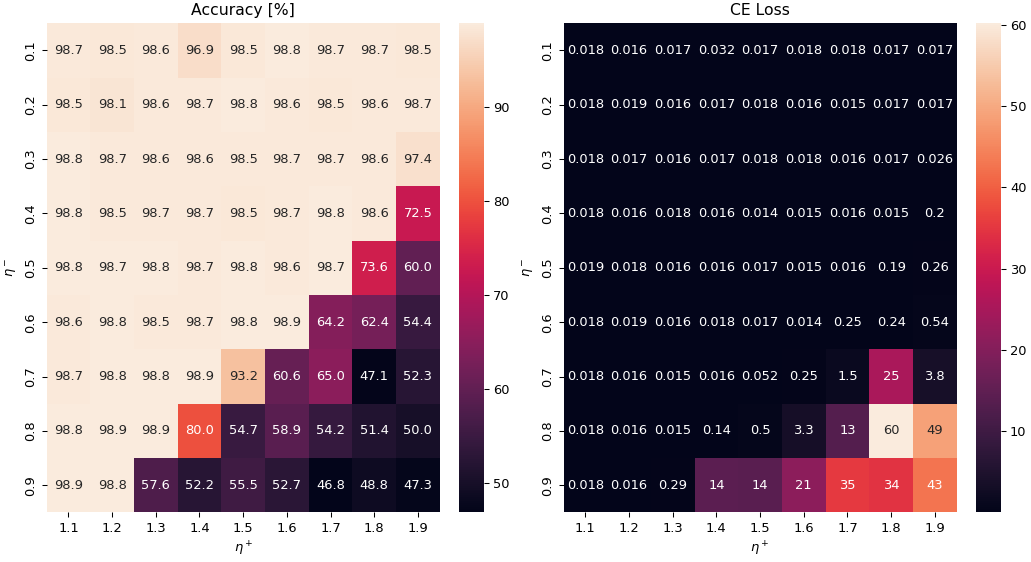

[Text(0.5, 1.0, 'CE Loss')]

In [26]:
%matplotlib notebook
fig2, ax2 = plt.subplots(1,2,figsize = (11,6),layout = 'constrained')

sns.heatmap(acc_train_grid,ax=ax2[0],annot = True,fmt= '.1f')
# sns.heatmap(acc_std_train_grid,ax=ax2[0,1],annot = True)

sns.heatmap(loss_train_grid,ax=ax2[1],annot = True)
# sns.heatmap(loss_std_train_grid,ax=ax2[1,1],annot = True)

ax2[0].set(xlabel="$\eta^+$", ylabel="$\eta^-$",xticklabels = (eta_high).numpy(),yticklabels = (eta_low).numpy())
ax2[0].set(title= "Accuracy [%]")

# ax2[0,1].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (eta_high).numpy(),yticklabels = (eta_low).numpy())
# ax2[0,1].set(title= "Accuracy Std dev. [%]")

ax2[1].set(xlabel="$\eta^+$", ylabel="$\eta^-$",xticklabels = (eta_high).numpy(),yticklabels = (eta_low).numpy())
ax2[1].set(title= "CE Loss")

# ax2[1,1].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (eta_high).numpy(),yticklabels = (eta_low).numpy())
# ax2[1,1].set(title= "CE Loss Std dev.")


In [27]:
plt.savefig('model3_CV_train',dpi = 200)

<IPython.core.display.Javascript object>


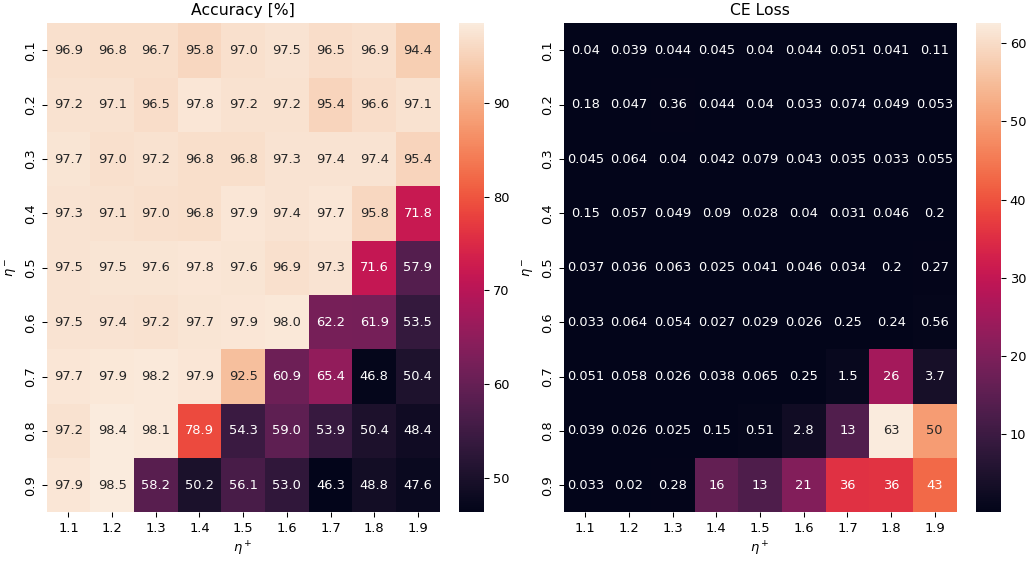

[Text(0.5, 1.0, 'CE Loss')]

In [28]:
fig3, ax3 = plt.subplots(1,2,figsize = (11,6),layout = 'constrained')

sns.heatmap(acc_test_grid,ax=ax3[0],annot = True,fmt= '.1f')
# sns.heatmap(acc_std_test_grid,ax=ax3[0,1],annot = True)

sns.heatmap(loss_test_grid,ax=ax3[1],annot = True)
# sns.heatmap(loss_std_test_grid,ax=ax3[1,1],annot = True)

ax3[0].set(xlabel="$\eta^+$", ylabel="$\eta^-$",xticklabels = (eta_high).numpy(),yticklabels = (eta_low).numpy())
ax3[0].set(title= "Accuracy [%]")

# ax3[0,1].set(xlabel="$\eta^+$", ylabel="$\eta^-$",xticklabels = (eta_high).numpy(),yticklabels = (eta_low).numpy())
# ax3[0,1].set(title= "Accuracy Std dev. [%]")

ax3[1].set(xlabel="$\eta^+$", ylabel="$\eta^-$",xticklabels = (eta_high).numpy(),yticklabels = (eta_low).numpy())
ax3[1].set(title= "CE Loss")

# ax3[1,1].set(xlabel="$\eta^+$", ylabel="$\eta^-$",xticklabels = (eta_high).numpy(),yticklabels = (eta_low).numpy())
# ax3[1,1].set(title= "CE Loss Std dev.")

In [29]:
plt.savefig('model3_CV_test',dpi = 200)

In [30]:
print("$\eta_-$ values:",eta_low)
print("$\eta_+$values:", eta_high)

print("\nTraining")
print("Maximum Accuracy",acc_train_grid.max(), "+-",acc_std_train_grid[acc_train_grid == acc_train_grid.max()])
print("$\eta_-$ at maximum accuracy:",nlow[acc_train_grid == acc_train_grid.max()])
print("$\eta_+$at maximum accuracy:",nhigh[acc_train_grid == acc_train_grid.max()])
print("Loss at maximum accuracy",loss_train_grid[acc_train_grid == acc_train_grid.max()],"+-",loss_std_train_grid[acc_train_grid == acc_train_grid.max()])

print("\n Minimum Loss",loss_train_grid.min(), "+-",loss_std_train_grid[loss_train_grid == loss_train_grid.min()])
print("$\eta_-$ at minimum loss:",nlow[loss_train_grid == loss_train_grid.min()])
print("$\eta_+$at minimum loss:",nhigh[loss_train_grid == loss_train_grid.min()])
print("Accuracy at minimum loss",acc_train_grid[loss_train_grid == loss_train_grid.min()],"+-",acc_std_train_grid[loss_train_grid == loss_train_grid.min()])

$\eta_-$ values: tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000])
$\eta_+$values: tensor([1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000, 1.9000])

Training
Maximum Accuracy tensor(98.9298) +- tensor([0.2821])
$\eta_-$ at maximum accuracy: tensor([0.7000])
$\eta_+$at maximum accuracy: tensor([1.4000])
Loss at maximum accuracy tensor([0.0158]) +- tensor([0.0029])

 Minimum Loss tensor(0.0142) +- tensor([0.0021])
$\eta_-$ at minimum loss: tensor([0.4000])
$\eta_+$at minimum loss: tensor([1.5000])
Accuracy at minimum loss tensor([98.5223]) +- tensor([0.5301])


In [31]:
print("\nTesting")
print("Maximum Accuracy",acc_test_grid.max(), "+-",acc_std_test_grid[acc_test_grid == acc_test_grid.max()])
print("$\eta_-$ at maximum accuracy:",nlow[acc_test_grid == acc_test_grid.max()])
print("$\eta_+$at maximum accuracy:",nhigh[acc_test_grid == acc_test_grid.max()])
print("Loss at maximum accuracy",loss_test_grid[acc_test_grid == acc_test_grid.max()],"+-",loss_std_test_grid[acc_test_grid == acc_test_grid.max()])

print("\n Minimum Loss",loss_test_grid.min(), "+-",loss_std_test_grid[loss_test_grid == loss_test_grid.min()])
print("$\eta_-$ at minimum loss:",nlow[loss_test_grid == loss_test_grid.min()])
print("$\eta_+$at minimum loss:",nhigh[loss_test_grid == loss_test_grid.min()])
print("Accuracy at minimum loss",acc_test_grid[loss_test_grid == loss_test_grid.min()],"+-",acc_std_test_grid[loss_test_grid == loss_test_grid.min()])


Testing
Maximum Accuracy tensor(98.5226) +- tensor([0.5198])
$\eta_-$ at maximum accuracy: tensor([0.9000])
$\eta_+$at maximum accuracy: tensor([1.2000])
Loss at maximum accuracy tensor([0.0205]) +- tensor([0.0066])

 Minimum Loss tensor(0.0205) +- tensor([0.0066])
$\eta_-$ at minimum loss: tensor([0.9000])
$\eta_+$at minimum loss: tensor([1.2000])
Accuracy at minimum loss tensor([98.5226]) +- tensor([0.5198])
